**Exercise 1:** Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [1]:
# Load in the data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [27]:
# Split into training and test set
X, y = mnist.data, mnist.target
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
(X_train.shape, y_train.shape)

((60000, 784), (60000,))

In [28]:
# Build a KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

kn_clf = KNeighborsClassifier(n_neighbors=5, weights="distance")

y_train_pred = cross_val_predict(kn_clf, X_train, y_train, cv=3)
y_train_pred

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [29]:
# Accuracy score with initial hyperparameters
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_train, y_train_pred)
round(acc_score*100, 2)

96.86

In [30]:
# Let's try some variations of the hyperparameters
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(kn_clf, {
    "n_neighbors": [2, 3, 5],
    "weights": ["distance"]
})

clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': [2, 3, 5], 'weights': ['distance']})

In [31]:
# Fitting the test set to the best estimator from the grid search achieves an accuracy > 97%!
kn_clf_best = clf.best_estimator_
y_pred = kn_clf_best.predict(X_test)
round(accuracy_score(y_test, y_pred)*100, 2)

97.17

**Exercise 2:**
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [43]:
# A function to shift an image one pixel to a given direction
from scipy.ndimage import shift

def shift_image(img, dir="left"):
    dirs = {
        "left": [0, -1],
        "right": [0, 1],
        "down": [1, 0],
        "up": [-1, 0]
    }
    if dir not in list(dirs.keys()):
        raise Exception("Incorrect <dir> argument.")
    
    return shift(img, dirs[dir], cval=0)


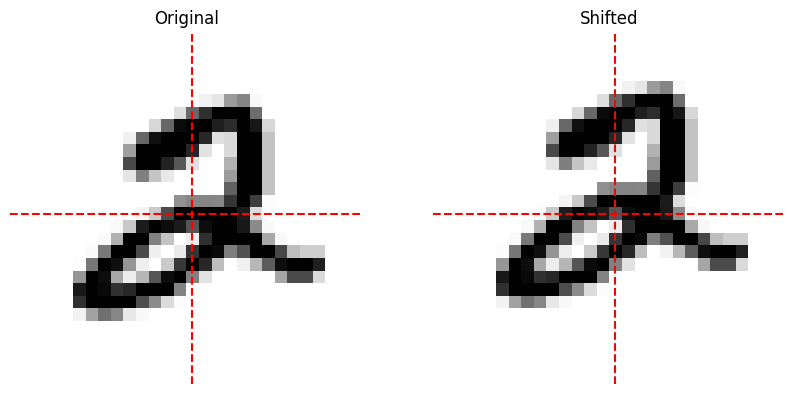

In [90]:
# Make sure that the shifting works
import matplotlib.pyplot as plt

def plot_digit(img, subplot, title):
    plt.subplot(subplot)
    plt.imshow(img, cmap="binary")
    plt.axhline(y=14, color='red', linestyle='--')
    plt.axvline(x=14, color='red', linestyle='--')
    plt.axis("off")
    plt.title(title)

ex_img = X_train[5].reshape(28, 28)
shifted = shift_image(ex_img, "up")

plt.figure(figsize=(10, 5))

plot_digit(ex_img, 121, "Original")
plot_digit(shifted, 122, "Shifted")

plt.show()

In [80]:
# Add four shifted copies of each digit to the training set
import numpy as np

X_train_augmented = np.zeros((X_train.shape[0] * 5, 784))

X_train_augmented[:X_train.shape[0]] = X_train

shifted_images = []
for img in X_train:
    img_reshaped = img.reshape(28,28)
    shifted_images.append(shift_image(img_reshaped, dir="left").reshape(1,784))
    shifted_images.append(shift_image(img_reshaped, dir="right").reshape(1,784))
    shifted_images.append(shift_image(img_reshaped, dir="up").reshape(1,784))
    shifted_images.append(shift_image(img_reshaped, dir="down").reshape(1,784))

X_train_augmented[X_train.shape[0]:] = np.vstack(shifted_images)
X_train_augmented.shape

(300000, 784)

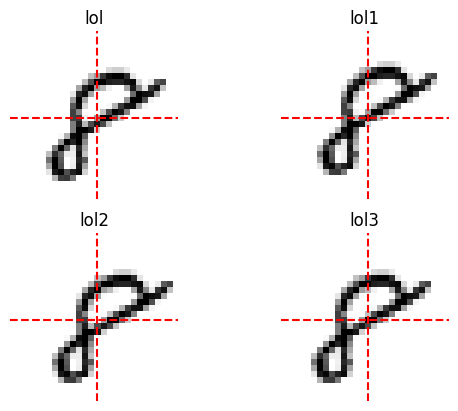

In [95]:
# Check that the shifts worked
plot_digit(X_train_augmented[59999].reshape(28,28), 221, "lol")
plot_digit(X_train_augmented[-2].reshape(28,28), 222, "lol1")
plot_digit(X_train_augmented[-3].reshape(28,28), 223, "lol2")
plot_digit(X_train_augmented[-4].reshape(28,28), 224, "lol3")

In [107]:
# Add the new set to the labels
y_train_aug = np.concatenate((y_train, np.repeat(y_train, 4)))

In [108]:
# Retrain the model
from sklearn.base import clone
kn_clf_aug = clone(kn_clf_best)
kn_clf_aug.fit(X_train_augmented, y_train_aug)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [109]:
# We get slightly better accuracy on the model trained on the augmented test set!
y_pred_aug = kn_clf_aug.predict(X_test)
round(accuracy_score(y_test, y_pred_aug)*100, 2)

97.63